# Imports

In [1]:
%pip install segmentation_models -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00


In [2]:
# !unzip /content/data.zip

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

from google.colab import drive
drive.mount('/content/drive')

Segmentation Models: using `tf.keras` framework.
Mounted at /content/drive


In [4]:
!cp '/content/drive/My Drive/Colab Notebooks/data.zip' /content

In [5]:
!unzip -q /content/data.zip

# Constants

In [6]:
seed = 13
batch_size = 16
target_size = (256, 256)

DATASET_FOLDER = f'/content/data'
#DATASET_FOLDER = f'/content/drive/My Drive/Colab Notebooks/data'
train_img_path = f'{DATASET_FOLDER}/train_images/img'
train_masks_path = f'{DATASET_FOLDER}/train_masks/img'
val_img_path = f'{DATASET_FOLDER}/val_images/img'
val_masks_path = f'{DATASET_FOLDER}/val_masks/img'

num_train_imgs = len(os.listdir(train_img_path))
num_val_images = len(os.listdir(val_img_path))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

backbone_network = 'resnet50'
model_checkpoint_path = "/content/drive/My Drive/Colab Notebooks/model_checkpoints/model-{epoch:02d}-{val_iou_score:.4f}" + f"unet_{backbone_network}.hdf5"

# Helper functions

In [7]:

def image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img/255, to_categorical(mask/255))

def create_generator_pair(img_path, mask_path):
    image_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    image_data_generator = image_data_generator.flow_from_directory(img_path[:-4],
                                                                    class_mode=None,
                                                                    batch_size=batch_size,
                                                                    target_size=target_size,
                                                                    seed=seed)

    mask_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    mask_data_generator = mask_data_generator.flow_from_directory(mask_path[:-4],
                                                                  class_mode=None,
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  target_size=target_size,
                                                                  seed=seed)

    return image_data_generator, mask_data_generator

def display_images(img_list):
    f, axarr = plt.subplots(1, len(img_list), figsize=(13,13))
    for x, img in enumerate(img_list):
        axarr[x].imshow(img)
    plt.show()

# Creation of data generator and sanity check

In [8]:
train_generator = image_mask_generator(*create_generator_pair(train_img_path, train_masks_path))
val_generator = image_mask_generator(*create_generator_pair(val_img_path, val_masks_path))

Found 4306 images belonging to 1 classes.
Found 4306 images belonging to 1 classes.
Found 1054 images belonging to 1 classes.
Found 1054 images belonging to 1 classes.


### Model creation

In [9]:
model = sm.Unet(backbone_network, input_shape=(256,256,3), classes=2, activation='softmax')
model.compile(optimizer='adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

94592056/94592056 [==============================] - 1s 0us/step


### Model training

In [10]:
checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_iou_score', verbose=2, save_best_only=True, mode='max')

history = model.fit(train_generator, epochs=100, steps_per_epoch=steps_per_epoch, verbose=2,
                    validation_data=val_generator, validation_steps=val_steps_per_epoch, callbacks=[checkpoint])

Epoch 1/100

Epoch 1: val_iou_score improved from -inf to 0.45562, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoints/model-01-0.4556unet_resnet50.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 - 169s - loss: 0.2544 - iou_score: 0.7653 - val_loss: 0.6404 - val_iou_score: 0.4556 - 169s/epoch - 628ms/step
Epoch 2/100

Epoch 2: val_iou_score improved from 0.45562 to 0.45565, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoints/model-02-0.4557unet_resnet50.hdf5
269/269 - 121s - loss: 0.2004 - iou_score: 0.8181 - val_loss: 0.6252 - val_iou_score: 0.4557 - 121s/epoch - 448ms/step
Epoch 3/100

Epoch 3: val_iou_score improved from 0.45565 to 0.46041, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoints/model-03-0.4604unet_resnet50.hdf5
269/269 - 116s - loss: 0.1949 - iou_score: 0.8237 - val_loss: 0.6368 - val_iou_score: 0.4604 - 116s/epoch - 430ms/step
Epoch 4/100

Epoch 4: val_iou_score improved from 0.46041 to 0.72810, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoints/model-04-0.7281unet_resnet50.hdf5
269/269 - 114s - loss: 0.1821 - iou_score: 0.8351 - val_loss: 0.3020 - val_iou_score: 0.7281 - 114s/epoch - 4

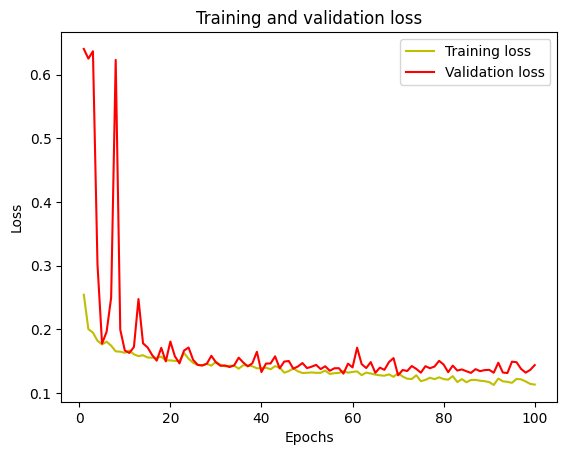

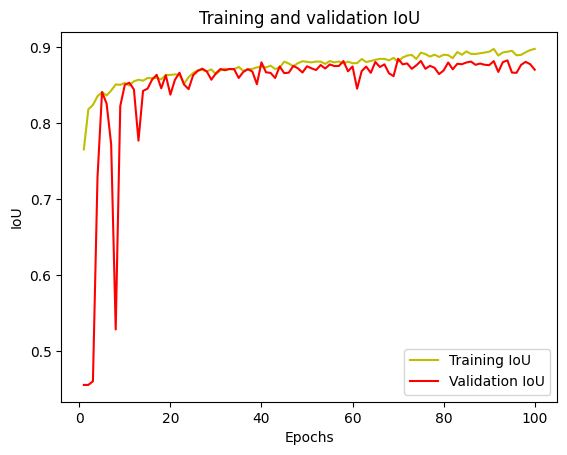

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()